## Topic Modelling with LDA

#### Dataset: netflix movie files

## Executive Summary
The goal of this project was to uncover meaningful topics within Netflix titles using topic modeling techniques, aiming to enhance understanding of the platform's content categorization. The dataset comprised 8,807 records, with attributes such as title, type, cast, director, country, release year, genres, and descriptions. The primary focus was on analyzing the "description" column to identify topics that could provide insights into Netflix's content diversity and help refine recommendations.

The preprocessing steps included cleaning the text by removing stop words, punctuation, and applying stemming. The descriptions were then vectorized using TF-IDF, followed by topic modeling using two methods: Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF). Both models aimed to extract distinct themes from the text, such as crime dramas, romantic comedies, and documentaries.

The LDA model produced interpretable topics but struggled with overlapping content across descriptions. On the other hand, the NMF model delivered higher coherence scores, indicating it was more effective in this context. Key topics identified by NMF included "crime thrillers," "family dramas," and "international series," which are in line with Netflix's audience segmentation strategies.

While NMF proved to be the more suitable model, there are opportunities for further enhancement. Future improvements could include fine-tuning hyperparameters, integrating additional metadata (e.g., genres and ratings), or exploring advanced deep learning-based models like BERTopic for more nuanced topic extraction. This project underscores the potential of topic modeling to improve content curation and better engage Netflix's diverse user base.

In [169]:
import warnings

warnings.filterwarnings('ignore')

In [170]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex
import sklearn
import langdetect
import pyLDAvis
import pyLDAvis.sklearn

import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk



from nltk.stem import PorterStemmer
from autocorrect import Speller


In [171]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sheyi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheyi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [173]:
import pyLDAvis
print(pyLDAvis.__version__)


3.4.0


## Loading the dataset

In [174]:
data = pd.read_csv('netflix_titles.csv')

In [175]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [176]:
# We will be using the movies description for our topic modelling
data_description = data['description'].tolist()
data_description[:5]

['As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.',
 'After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.',
 'To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.',
 'Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series.',
 'In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life.']

In [177]:
# Total Record
print(f"Total Record {len(data_description)}")

Total Record 8807


In [178]:
# Detect the language
try: 
    lang = langdetect.detect(data_description[4])
except: lang = 'none'

print(f"Language: {lang}")

Language: en


In [179]:
# Initialize the spell checker and stemmer
spell = Speller()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function for text preprocessing
def preprocess_text(text):
    # Correct spelling mistakes
    text = spell(text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = regex.sub(r'[^a-zA-Z\s]', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove @mentions
    text = re.sub(r'@\S+', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stem the words
    tokens = [stemmer.stem(word) for word in tokens]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# Data Cleaning

In [180]:
# Apply the preprocessing on the ddescription feild
data['description_cleaned'] = data['description'].dropna().apply(preprocess_text)

In [182]:
data['description_cleaned']

0       [father, near, end, life, filmmak, kirsten, jo...
1       [cross, path, parti, cape, town, teen, set, pr...
2       [protect, famili, power, drug, lord, skill, th...
3       [feud, flirtat, toilet, talk, go, among, incar...
4       [citi, coach, center, known, train, india, fin...
                              ...                        
8802    [polit, cartoonist, crime, report, pair, cop, ...
8803    [live, alon, spooki, town, young, girl, befrie...
8804    [look, surviv, world, taken, zombi, work, coll...
8805    [drag, civilian, life, former, superhero, must...
8806    [crappi, poor, boy, worm, way, tycoon, dysfunc...
Name: description_cleaned, Length: 8807, dtype: object

In [183]:
# Display Processed Test
data['description_cleaned_merged'] = data['description_cleaned'].apply(lambda x: ' '.join(x))
data['description_cleaned_merged']

0       father near end life filmmak kirsten johnson s...
1       cross path parti cape town teen set prove whet...
2       protect famili power drug lord skill thief med...
3       feud flirtat toilet talk go among incarcer wom...
4       citi coach center known train india finest col...
                              ...                        
8802    polit cartoonist crime report pair cop investi...
8803    live alon spooki town young girl befriend moth...
8804    look surviv world taken zombi work colleg stud...
8805    drag civilian life former superhero must train...
8806    crappi poor boy worm way tycoon dysfunct famil...
Name: description_cleaned_merged, Length: 8807, dtype: object

### Declaring Functions

In [184]:
# Function to calculate perplexity
def calculate_perplexity(model, vectorized_data):
    return model.perplexity(vectorized_data)


# Function to extract word-topic matrix from LDA or NMF
def word_to_topic(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(f"Topic {topic_idx + 1}: " + ", ".join(top_words))
    return topics



    # Function to extract document-topic matrix
def document_to_topic(model, vectorized_data):
    return model.transform(vectorized_data)



def plot_tsne(data, threshold):
    # filter data according to threshold
    index_meet_threshold = np.amax(data, axis=1) >= threshold
    lda_transform_filt = data[index_meet_threshold]
    n_samples = lda_transform_filt.shape[0]
    print(f"Using n_samples: {n_samples}")
    
    perplexity_value = min(30, max(5, n_samples - 1))  # Ensure it's at least 5 and less than n_samples
    print(f"Using perplexity: {perplexity_value}")

    # fit tsne model
    tsne = sklearn.manifold.TSNE(
        n_components=2, 
        #perplexity=n_samples,
        verbose=0, 
        random_state=0, 
        angle=0.5, 
        init='pca'
    )
    tsne_fit = tsne.fit_transform(lda_transform_filt)
    
    # most probable topic for each headline
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(lda_transform_filt[i].argmax())
    
    print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = np.unique(
        np.array(most_prob_topic), 
        return_counts=True
    )

    print("COUNTS:\n{}\n".format(np.asarray((unique, counts)).T))
    
    # make plot
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

    for i in list(set(most_prob_topic)):
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        plt.scatter(
            x=tsne_fit[indices, 0], 
            y=tsne_fit[indices, 1], 
            s=0.5, 
            c=color_list[i], 
            label='Topic' + str(i),
            alpha=0.25
        )

    plt.xlabel('x-tsne')
    plt.ylabel('y-tsne')
    plt.legend(markerscale=10)
    plt.show()

In [185]:
# Function to get topic assignments for each document
def get_topic_assignments(model, vectorized_data):
    # Transform the vectorized data to get document-topic distributions
    doc_topic_dist = model.transform(vectorized_data)
    # Assign each document the topic with the highest probability
    topic_assignments = np.argmax(doc_topic_dist, axis=1)
    return topic_assignments
    


# Function to plot t-SNE visualization
def plot_tsne_2(model, vectorized_data, n_components=2, random_state=42):
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

    # Get topic assignments
    topic_assignments = get_topic_assignments(model, vectorized_data)
    
    # Apply t-SNE on the document-topic matrix
    tsne = TSNE(n_components=n_components, angle=0.5, init='pca' ,random_state=random_state, verbose=0)
    
    tsne_results = tsne.fit_transform(model.transform(vectorized_data))

    # Map each document to a color based on its topic assignment
    colors = [color_list[topic] for topic in topic_assignments]

    
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, s=5, alpha=0.5)
    plt.title('t-SNE visualization of topics')
    plt.show()
   


In [186]:
def get_topics(mod, vec, names, docs, ndocs, nwords):
    # word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, np.newaxis]
    # topic to document matrix
    H = mod.transform(vec)
    
    W_dict = {}
    H_dict = {}
    
    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = "Topic{}".format(tpc_idx)
        
        # formatting w
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [
            (round(tpc_val[j], 4), names[j]) 
            for j in W_indices
        ]
        W_dict[topic] = W_names_values
        
        # formatting h
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [
            (round(H[:, tpc_idx][j], 4), docs[j]) 
            for j in H_indices
        ]
        H_dict[topic] = H_names_values
        
    W_df = pd.DataFrame(
        W_dict, 
        index=["Word" + str(i) for i in range(nwords)]
    )
    H_df = pd.DataFrame(
        H_dict,
        index=["Doc" + str(i) for i in range(ndocs)]
    )
        
    return (W_df, H_df)

# Vectorization

### Basic Count Vectorizer for LDA

In [187]:
# Vectorize text data for LDA and NMF
count_vectorizer = CountVectorizer(max_features=5000)

X_count = count_vectorizer.fit_transform(data['description_cleaned_merged'])


In [189]:
# display the tokenize text Count Vectorization
print(X_count[5])

  (0, 4569)	1
  (0, 210)	1
  (0, 629)	1
  (0, 4983)	1
  (0, 3379)	1
  (0, 486)	1
  (0, 2746)	1
  (0, 3025)	1
  (0, 2848)	1
  (0, 3649)	1
  (0, 3632)	1
  (0, 1064)	1
  (0, 1034)	1
  (0, 354)	1


### Basic TDIF Vectorizer for NMF

In [190]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_tfidf = tfidf_vectorizer.fit_transform(data['description_cleaned_merged'])

In [191]:
# display the tokenize text TDIF Vectorization
print(X_tfidf[5])

  (0, 354)	0.27392288011867283
  (0, 1034)	0.24471182036779385
  (0, 1064)	0.24188239215712434
  (0, 3632)	0.29467714477639423
  (0, 3649)	0.35711588792636795
  (0, 2848)	0.18687911818096217
  (0, 3025)	0.3373086889907303
  (0, 2746)	0.31684810253222206
  (0, 486)	0.21159069240104636
  (0, 3379)	0.29663762156175016
  (0, 4983)	0.14726703896122628
  (0, 629)	0.2910102546792621
  (0, 210)	0.24837871046492602
  (0, 4569)	0.20563123041119422


### Note: 
We will create another Count and TDIF Vectorizer with more parameters later on

## Global Variables 

In [192]:
# define some global variables

number_words = 10
number_docs = 10
number_features = 1000

# Modelling

In [193]:
# Function to train LDA model
def train_lda_model(X, n_topics, max_iter=10, learning_method='online', random_state=42):
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter,
                                    learning_method=learning_method, random_state=random_state)
    lda.fit(X)
    return lda

# Function to train NMF model
def train_nmf_model(X, n_topics, max_iter=10, random_state=42):
    nmf = NMF(n_components=n_topics, max_iter=max_iter, random_state=random_state)
    nmf.fit(X)
    return nmf

## First Model - Latent Dirichlet Allocation (LDA) with 10 Topics

In [194]:
# Train LDA and NMF models
lda_model = train_lda_model(X_count, n_topics=10)
lda_model

LatentDirichletAllocation(learning_method='online', random_state=42)

In [195]:
def lda_model_evaluation(model, vector, vectorizer, feature_names_vec, data, lda_transform):
    print(f"LDA Perplexity: {calculate_perplexity(model, vector)}")
    
    lda_topics = word_to_topic(model, vectorizer.get_feature_names_out())
    print("LDA Topics:")
    for topic in lda_topics:
        print(topic)

    W_df, H_df = get_topics(
        mod=model,
        vec=vector,
        names=feature_names_vec,
        docs=data,
        ndocs=number_docs, 
        nwords=number_words
    )

    # word-topic table
    print("---- Word To Topics")
    print(W_df)

    lda_doc_topics = document_to_topic(model, vector)
    print(f"\nLDA Document-Topic matrix (first 5 rows):\n{lda_doc_topics[:5]}")

     # word-topic table
    print("---- Document To Topics")
    print(H_df)
    
    # Plot t-SNE for LDA topics
    plot_tsne_2(model, vector)

    plot_tsne(data=lda_transform, threshold=0.75)

In [196]:
def nmf_model_evaluation(model, vector, vectorizer, feature_names_vec, data, nmf_transform):
    
    
    nmf_topics = word_to_topic(model, vectorizer.get_feature_names_out())
    print("NMF Topics:")
    for topic in nmf_topics:
        print(topic)

    W_df, H_df = get_topics(
        mod=model,
        vec=vector,
        names=feature_names_vec,
        docs=data,
        ndocs=number_docs, 
        nwords=number_words
    )

    # word-topic table
    print("---- Word To Topics")
    print(W_df)

    nmf_doc_topics = document_to_topic(model, vector)
    print(f"\nLDA Document-Topic matrix (first 5 rows):\n{nmf_doc_topics[:5]}")

     # word-topic table
    print("---- Document To Topics")
    print(H_df)
    
    # Plot t-SNE for NMF topics
    plot_tsne_2(model, vector)

    

#### Perplexity of first model

In [197]:
# Calculate perplexity for LDA 
lda_perplexity = calculate_perplexity(lda_model, X_count)

print(f"LDA Perplexity: {lda_perplexity}")

LDA Perplexity: 3495.842085368556


#### Word to Topic

In [199]:
# Display word-topic matrices
lda_topics = word_to_topic(lda_model, count_vectorizer.get_feature_names_out())


print("LDA Topics:")
for topic in lda_topics:
    print(topic)


LDA Topics:
Topic 1: year, murder, mysteri, offic, killer, prison, fight, past, night, famili
Topic 2: war, anim, land, crew, around, gang, countri, standup, lose, grow
Topic 3: two, team, power, take, world, run, brother, drug, forc, polit
Topic 4: love, man, woman, fall, becom, young, marri, lead, cultur, four
Topic 5: yearold, town, troubl, parent, get, adventur, take, famili, childhood, magic
Topic 6: death, investig, tri, life, former, agent, crime, job, work, keep
Topic 7: life, documentari, stori, live, love, becom, woman, relationship, two, romanc
Topic 8: new, special, man, wife, use, young, share, chang, live, travel
Topic 9: school, friend, high, find, back, student, time, new, learn, make
Topic 10: girl, person, seri, follow, battl, singl, set, america, give, brutal


#### Detailed Evaluation Summary

In [202]:
# Display document-topic matrices
lda_doc_topics = document_to_topic(lda_model, X_count)

print(f"\nLDA Document-Topic matrix (first 5 rows):\n{lda_doc_topics[:5]}")



LDA Document-Topic matrix (first 5 rows):
[[0.00666668 0.00666687 0.00666694 0.00666711 0.00666687 0.9399913
  0.0066689  0.00666724 0.00667142 0.00666668]
 [0.00666694 0.00666681 0.93998622 0.00666691 0.00667565 0.00666673
  0.00666873 0.0066673  0.00666773 0.00666699]
 [0.00588375 0.00588264 0.88507981 0.0058825  0.00588252 0.00588273
  0.00588245 0.06785786 0.00588308 0.00588266]
 [0.11039727 0.00625005 0.00625    0.00625075 0.00625037 0.74429776
  0.00625051 0.006252   0.0062516  0.1015497 ]
 [0.00666667 0.00666833 0.0066693  0.00666725 0.00667041 0.93997988
  0.00666721 0.00667    0.006674   0.00666695]]


LDA Perplexity: 3495.842085368556
LDA Topics:
Topic 1: year, murder, mysteri, offic, killer, prison, fight, past, night, famili
Topic 2: war, anim, land, crew, around, gang, countri, standup, lose, grow
Topic 3: two, team, power, take, world, run, brother, drug, forc, polit
Topic 4: love, man, woman, fall, becom, young, marri, lead, cultur, four
Topic 5: yearold, town, troubl, parent, get, adventur, take, famili, childhood, magic
Topic 6: death, investig, tri, life, former, agent, crime, job, work, keep
Topic 7: life, documentari, stori, live, love, becom, woman, relationship, two, romanc
Topic 8: new, special, man, wife, use, young, share, chang, live, travel
Topic 9: school, friend, high, find, back, student, time, new, learn, make
Topic 10: girl, person, seri, follow, battl, singl, set, america, give, brutal
---- Word To Topics
                  Topic0             Topic1             Topic2  \
Word0     (0.0295, year)      (0.0146, war)      (0.0217, two)   
Word1   (0.0256, murder) 

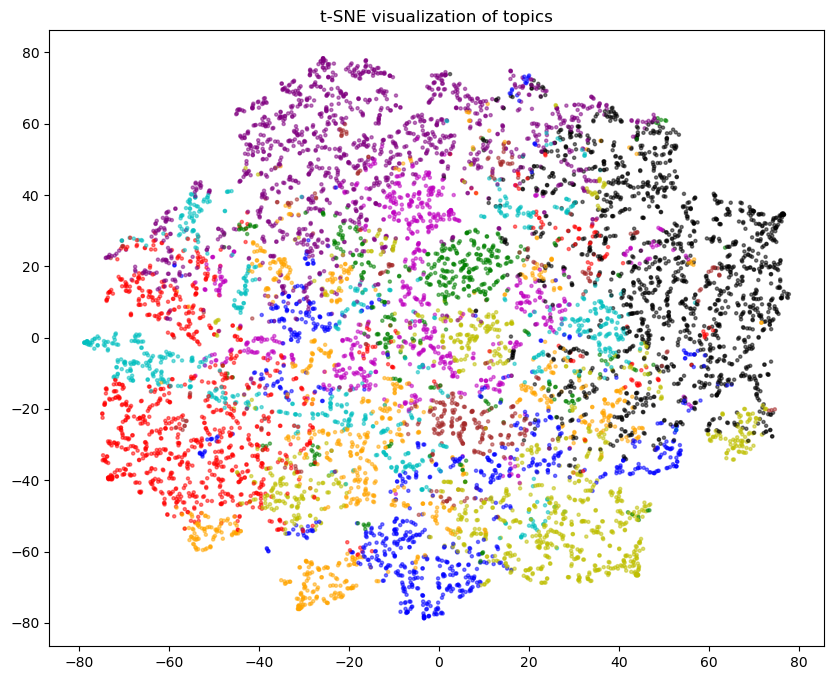

Using n_samples: 143
Using perplexity: 30
LENGTH:
143

COUNTS:
[[ 0 12]
 [ 1  4]
 [ 2 18]
 [ 3 15]
 [ 4 12]
 [ 5 15]
 [ 6 24]
 [ 7 17]
 [ 8 19]
 [ 9  7]]



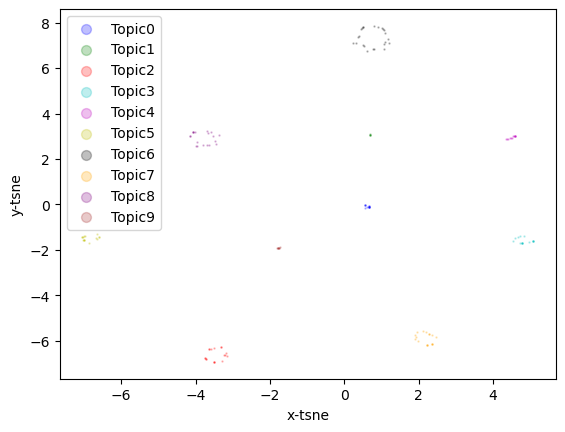

In [203]:
feature_names_vec = count_vectorizer.get_feature_names_out()
lda_transform = lda_model.transform(X_count)
lda_model_evaluation(lda_model, X_count, count_vectorizer, feature_names_vec, data['description_cleaned_merged'], lda_transform)

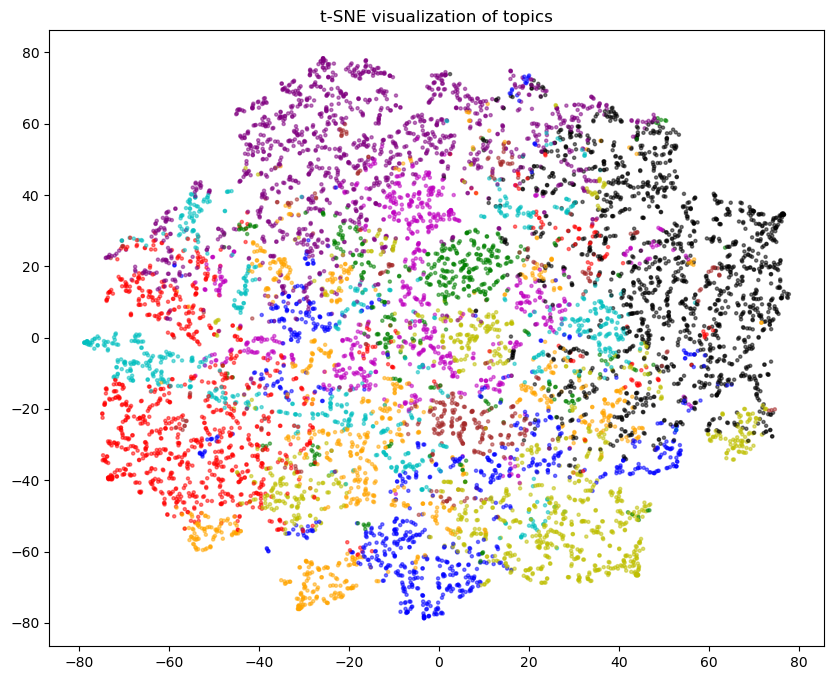

In [204]:
# Plot t-SNE for LDA topics
plot_tsne_2(lda_model, X_count)

## First Model - Non-negative Matrix Factorization (NMF) with 10 Topics

In [205]:
nmf_model = train_nmf_model(X_tfidf, n_topics=10)
nmf_model

NMF(max_iter=10, n_components=10, random_state=42)

In [206]:
# Calculate perplexity for NMF
nmf_perplexity = mean_squared_error(X_tfidf.toarray(), nmf_model.transform(X_tfidf).dot(nmf_model.components_))

print(f"NMF Perplexity: {nmf_perplexity}")

NMF Perplexity: 0.00019378388664543532


In [207]:
# Display word-topic matrices

nmf_topics = word_to_topic(nmf_model, tfidf_vectorizer.get_feature_names_out())

print("\nNMF Topics:")
for topic in nmf_topics:
    print(topic)


NMF Topics:
Topic 1: world, one, make, learn, save, adventur, dream, tri, time, way
Topic 2: young, man, woman, father, marri, mother, fall, becom, meet, girl
Topic 3: documentari, seri, stori, follow, explor, film, base, life, comedi, true
Topic 4: murder, investig, must, forc, power, detect, mysteri, crime, team, cop
Topic 5: school, high, student, teen, colleg, girl, teacher, romanc, navig, group
Topic 6: new, life, york, citi, move, home, begin, start, town, past
Topic 7: famili, father, home, return, brother, year, secret, struggl, son, sister
Topic 8: friend, best, get, take, help, turn, two, childhood, adventur, trip
Topic 9: find, love, fall, way, romanc, true, work, life, come, marri
Topic 10: live, two, woman, three, differ, year, coupl, chang, share, four


In [208]:
# Display document-topic matrices
nmf_doc_topics = document_to_topic(nmf_model, X_tfidf)

print(f"\nNMF Document-Topic matrix (first 5 rows):\n{nmf_doc_topics[:5]}")




NMF Document-Topic matrix (first 5 rows):
[[0.0114249  0.01504555 0.02368925 0.01208424 0.         0.03359558
  0.02070061 0.01064869 0.01264192 0.        ]
 [0.00908334 0.00428901 0.00743791 0.0199781  0.01880674 0.00488651
  0.0079746  0.00188156 0.00755045 0.00283815]
 [0.00066451 0.         0.00212301 0.07519319 0.         0.
  0.06354167 0.         0.         0.        ]
 [0.         0.02869361 0.03222336 0.         0.         0.06001447
  0.         0.         0.         0.00847673]
 [0.         0.         0.01037411 0.         0.04759838 0.05167248
  0.         0.05656054 0.         0.        ]]


NMF Topics:
Topic 1: world, one, make, learn, save, adventur, dream, tri, time, way
Topic 2: young, man, woman, father, marri, mother, fall, becom, meet, girl
Topic 3: documentari, seri, stori, follow, explor, film, base, life, comedi, true
Topic 4: murder, investig, must, forc, power, detect, mysteri, crime, team, cop
Topic 5: school, high, student, teen, colleg, girl, teacher, romanc, navig, group
Topic 6: new, life, york, citi, move, home, begin, start, town, past
Topic 7: famili, father, home, return, brother, year, secret, struggl, son, sister
Topic 8: friend, best, get, take, help, turn, two, childhood, adventur, trip
Topic 9: find, love, fall, way, romanc, true, work, life, come, marri
Topic 10: live, two, woman, three, differ, year, coupl, chang, share, four
---- Word To Topics
                   Topic0            Topic1                 Topic2  \
Word0     (0.0288, world)   (0.0559, young)  (0.0199, documentari)   
Word1       (0.0155, one)     (0.0439, man)         (0.0181, se

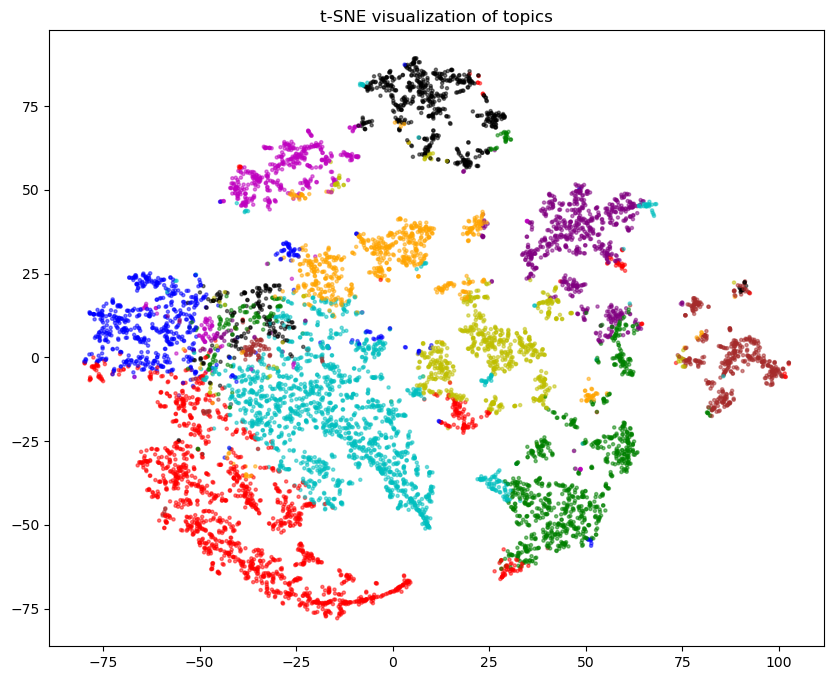

In [210]:
feature_names_vec_nmf = tfidf_vectorizer.get_feature_names_out()
nmf_tf = nmf_model.transform(X_tfidf)
nmf_model_evaluation(nmf_model, X_tfidf, tfidf_vectorizer, feature_names_vec_nmf, data['description_cleaned_merged'], nmf_tf)

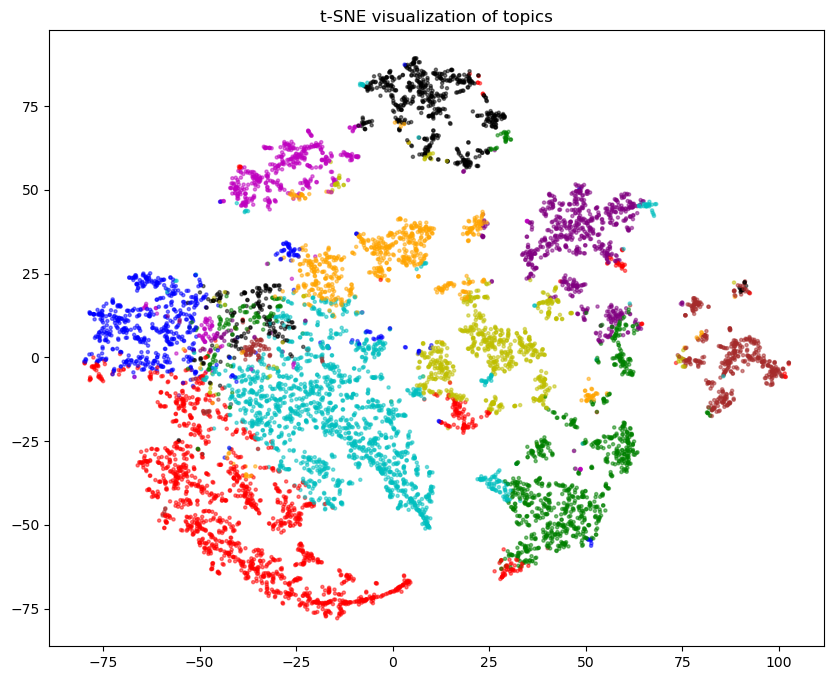

In [109]:
# Plot t-SNE for LDA topics
plot_tsne_2(nmf_model, X_tfidf)

# Different Parameters for LDA with Count Vectorizer


In [211]:
c_vectorizer = CountVectorizer(
    analyzer="word",
    max_df=0.5, 
    min_df=20, 
    max_features=number_features
)
X_count_2 = c_vectorizer.fit_transform(data['description_cleaned_merged'])
print(X_count_2[0])

feature_names_vec1 = c_vectorizer.get_feature_names_out()
feature_names_vec1[0:6]

  (0, 334)	1
  (0, 598)	1
  (0, 288)	1
  (0, 519)	1
  (0, 348)	1
  (0, 831)	1
  (0, 228)	1
  (0, 472)	1
  (0, 171)	1
  (0, 969)	1
  (0, 416)	1
  (0, 320)	1


array(['abandon', 'abil', 'abus', 'academi', 'accept', 'accid'],
      dtype=object)

In [212]:
# define function to calculate perplexity for LDA model trained on ntopics

def perplexity_by_ntopic(data, ntopics):
    output_dict = {
        "Number Of Topics": [], 
        "Perplexity Score": []
    }
    
    for t in ntopics:
        lda = sklearn.decomposition.LatentDirichletAllocation(
            n_components=t,
            learning_method="online",
            random_state=0
        )
        lda.fit(data)
        
        output_dict["Number Of Topics"].append(t)
        output_dict["Perplexity Score"].append(lda.perplexity(data))
        
    output_df = pd.DataFrame(output_dict)
    
    index_min_perplexity = output_df["Perplexity Score"].idxmin()
    output_num_topics = output_df.loc[
        index_min_perplexity,  # index
        "Number Of Topics"  # column
    ]
        
    return (output_df, output_num_topics)



In [213]:
# find perplexity scores for several different numbers of topics
# takes several minutes

df_perplexity, optimal_num_topics = perplexity_by_ntopic(
    X_count_2, 
    ntopics=[1, 2, 3, 4, 6, 8, 10]
)

In [214]:
print(df_perplexity)

   Number Of Topics  Perplexity Score
0                 1        711.280238
1                 2        723.585758
2                 3        757.254750
3                 4        840.505884
4                 6        937.251523
5                 8        995.037762
6                10       1057.058486


<Axes: xlabel='Number Of Topics'>

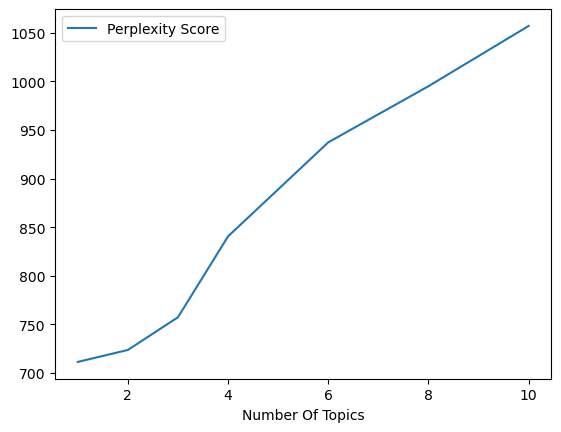

In [215]:
df_perplexity.plot.line("Number Of Topics", "Perplexity Score")

### We will use 3 topics to try

In [216]:
# Train LDA and NMF models
lda_model_2 = train_lda_model(X_count_2, n_topics=3)
lda_model_2

LatentDirichletAllocation(learning_method='online', n_components=3,
                          random_state=42)

In [217]:
lda_2_transform = lda_model_2.transform(X_count_2)
print(lda_2_transform.shape)
print(lda_2_transform)

(8807, 3)
[[0.33993243 0.62991994 0.03014763]
 [0.83526624 0.0331154  0.13161836]
 [0.02469966 0.93081774 0.0444826 ]
 ...
 [0.51153027 0.14506536 0.34340437]
 [0.22672744 0.73671316 0.03655939]
 [0.35530447 0.47695135 0.16774418]]


In [218]:

lda_2_components = lda_model_2.components_
print(lda_2_components.shape)
print(lda_2_components)

(3, 1000)
[[3.60699395e+01 1.15527417e+01 7.30641460e-01 ... 7.32134928e+02
  3.39444120e+01 5.42496636e+00]
 [3.75717352e-01 4.10496843e-01 3.66793793e-01 ... 2.12568257e+00
  3.47975464e-01 1.91237257e+01]
 [3.73188540e-01 2.27735478e+01 4.74334795e+01 ... 9.69266212e+00
  3.47108705e-01 5.75178714e+00]]


In [219]:
# iterative visualization
# featuring pca biplot and histogram
# Custom function to get vocabulary
def _get_vocab(vectorizer):
    try:
        return vectorizer.get_feature_names_out()
    except AttributeError:
        return vectorizer.get_feature_names()

# Custom function to extract data
def _extract_data(lda_model, dtm, vectorizer):
    vocab = _get_vocab(vectorizer)
    doc_lengths = np.array(dtm.sum(axis=1)).flatten()
    term_freqs = np.array(dtm.sum(axis=0)).flatten()
    return {
        'topic_term_dists': lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis],
        'doc_topic_dists': lda_model.transform(dtm),
        'doc_lengths': doc_lengths,
        'vocab': vocab,
        'term_frequency': term_freqs
    }

# Prepare the LDA visualization
lda_plot = pyLDAvis.prepare(**_extract_data(lda_model_2, X_count_2, c_vectorizer), mds='tsne', R=10)
pyLDAvis.display(lda_plot)

## Evaluate the Second LDA Model

LDA Perplexity: 770.8222730864424
LDA Topics:
Topic 1: young, woman, find, love, man, famili, life, get, two, three
Topic 2: new, take, team, power, save, fight, friend, world, citi, special
Topic 3: life, documentari, seri, world, stori, school, mysteri, live, follow, show
---- Word To Topics
                 Topic0             Topic1                 Topic2
Word0   (0.0219, young)      (0.0193, new)         (0.0151, life)
Word1   (0.0199, woman)     (0.0134, take)  (0.0151, documentari)
Word2    (0.0174, find)     (0.0128, team)         (0.0148, seri)
Word3    (0.0166, love)     (0.012, power)        (0.0134, world)
Word4     (0.0157, man)     (0.0113, save)         (0.013, stori)
Word5  (0.0146, famili)    (0.0106, fight)       (0.0126, school)
Word6    (0.0115, life)   (0.0101, friend)      (0.0107, mysteri)
Word7     (0.0104, get)      (0.01, world)         (0.0103, live)
Word8     (0.0102, two)     (0.0098, citi)       (0.0093, follow)
Word9   (0.0086, three)  (0.0095, special)   

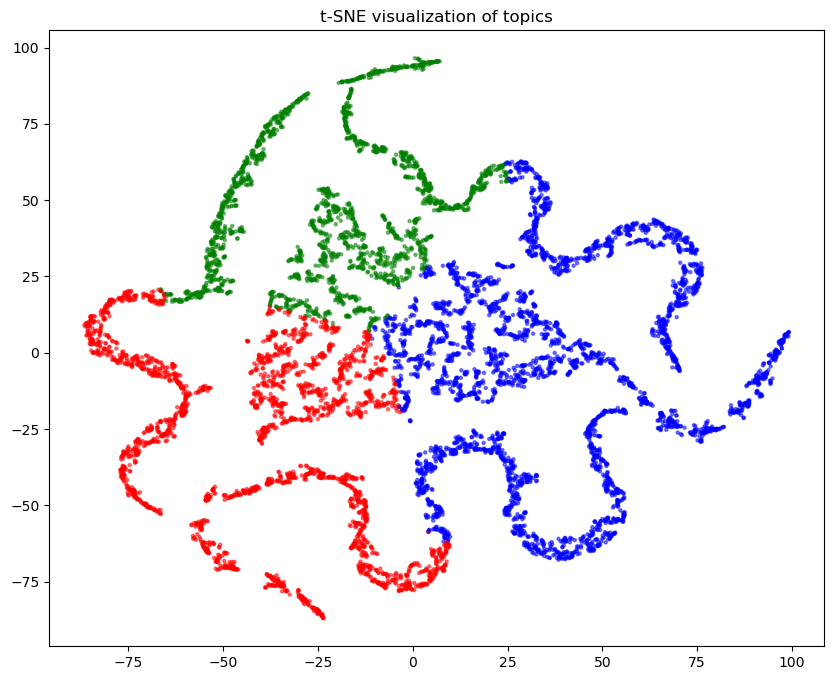

Using n_samples: 2204
Using perplexity: 30
LENGTH:
2204

COUNTS:
[[   0 1148]
 [   1  384]
 [   2  672]]



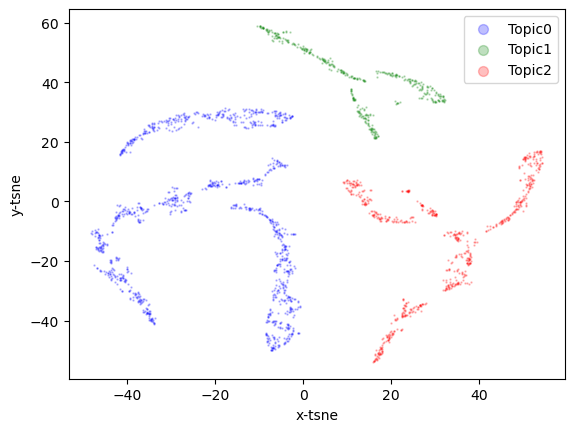

In [220]:
lda_model_evaluation(lda_model_2, X_count_2, c_vectorizer, feature_names_vec1, data['description_cleaned_merged'], lda_2_transform)

## Try LDA with 2 Topics

In [221]:
# Train LDA and NMF models
lda_model_3 = train_lda_model(X_count_2, n_topics=2)
lda_model_3

LatentDirichletAllocation(learning_method='online', n_components=2,
                          random_state=42)

In [222]:
lda_3_transform = lda_model_3.transform(X_count_2)
print(lda_3_transform.shape)
print(lda_3_transform)

lda_3_components = lda_model_3.components_
print(lda_3_components.shape)
print(lda_3_components)

(8807, 2)
[[0.44811703 0.55188297]
 [0.83571136 0.16428864]
 [0.38099975 0.61900025]
 ...
 [0.57522753 0.42477247]
 [0.21430919 0.78569081]
 [0.75369551 0.24630449]]
(2, 1000)
[[3.60685788e+01 2.34988494e+01 3.99250313e+01 ... 7.42424322e+02
  3.40916545e+01 8.67388705e+00]
 [7.50266483e-01 1.12379369e+01 8.60588347e+00 ... 1.52895098e+00
  5.47841648e-01 2.16265921e+01]]


## Evaluating the Third Model

LDA Perplexity: 722.413975272748
LDA Topics:
Topic 1: young, find, woman, love, famili, man, life, two, get, becom
Topic 2: world, friend, new, seri, documentari, take, life, school, team, group
---- Word To Topics
                Topic0                 Topic1
Word0  (0.0171, young)        (0.0149, world)
Word1    (0.016, find)       (0.0118, friend)
Word2  (0.0154, woman)          (0.0113, new)
Word3   (0.0134, love)         (0.0105, seri)
Word4  (0.013, famili)  (0.0101, documentari)
Word5    (0.0121, man)         (0.0096, take)
Word6   (0.0104, life)         (0.0089, life)
Word7    (0.0093, two)       (0.0089, school)
Word8    (0.0076, get)         (0.0075, team)
Word9  (0.0074, becom)         (0.007, group)

LDA Document-Topic matrix (first 5 rows):
[[0.44811703 0.55188297]
 [0.83571136 0.16428864]
 [0.38099975 0.61900025]
 [0.35372929 0.64627071]
 [0.04904465 0.95095535]]
---- Document To Topics
                                                 Topic0  \
Doc0  (0.97, wealthi despic

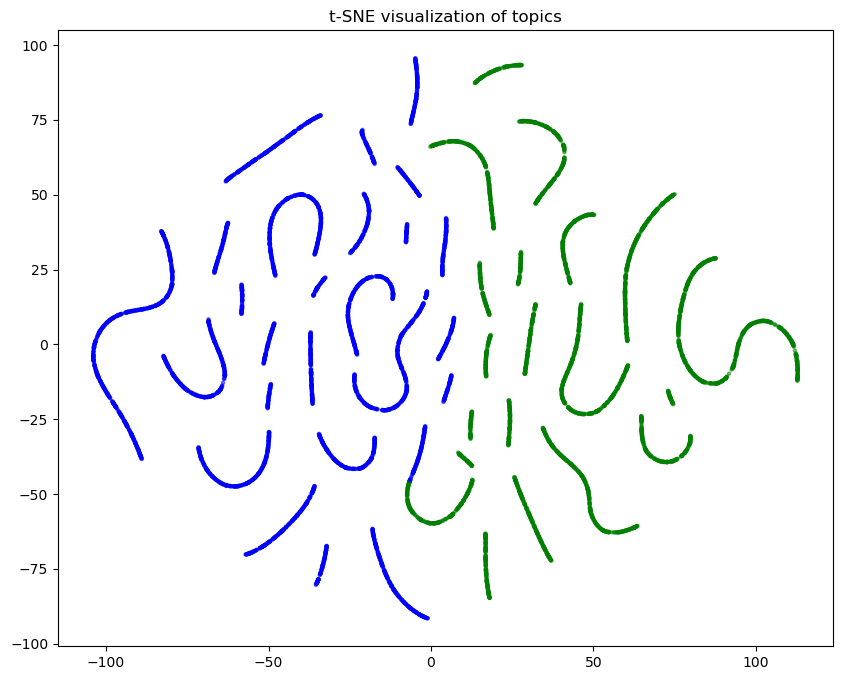

Using n_samples: 4762
Using perplexity: 30
LENGTH:
4762

COUNTS:
[[   0 2603]
 [   1 2159]]



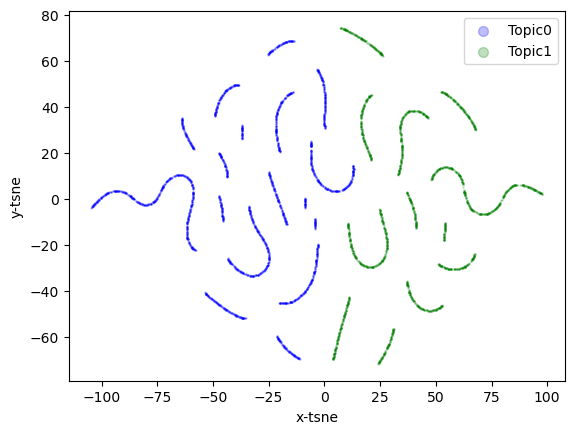

In [223]:
lda_model_evaluation(lda_model_3, X_count_2, c_vectorizer, feature_names_vec1, data['description_cleaned_merged'], lda_3_transform)

In [224]:
# Prepare the LDA visualization
lda_3_plot = pyLDAvis.prepare(**_extract_data(lda_model_3, X_count_2, c_vectorizer), mds='tsne', R=10)
pyLDAvis.display(lda_3_plot)

## Choice of Best Model

#### Best LDA Model

We will go with the 3 topics despite its perplexity score is higher that 2 topics. we want to see more variations and topics on the netflix dataset. The nexflix movies description is very complex but  we will attempt to define the topics based on the words within the topics

# Different Parameters for NMF and TDIF Vectorizer

In [225]:
# use tf-idf method this time

nmf_vectorizer2 = TfidfVectorizer(
    analyzer="word",
    max_df=0.5, 
    min_df=20, 
    max_features=number_features,
    smooth_idf=False
)
X_tdif_2 = nmf_vectorizer2.fit_transform(data['description_cleaned_merged'])
print(X_tdif_2[0])

  (0, 320)	0.25583203152792355
  (0, 416)	0.23111342272001364
  (0, 969)	0.2604321717740685
  (0, 171)	0.2931748490497754
  (0, 472)	0.37490938499493026
  (0, 228)	0.2657250415946232
  (0, 831)	0.3031179525315405
  (0, 348)	0.3187320496162626
  (0, 519)	0.19028836894173395
  (0, 288)	0.2959754307267232
  (0, 598)	0.37490938499493026
  (0, 334)	0.24156681493890983


In [226]:
# Get The Featuers name
feature_names_vec3 = nmf_vectorizer2.get_feature_names_out()
feature_names_vec3[0:10]

array(['abandon', 'abil', 'abus', 'academi', 'accept', 'accid',
       'accident', 'account', 'accus', 'across'], dtype=object)

#### Second NMF cModel with new Parameters

In [227]:
# define and fit nmf model

nmf_2_model = NMF(
    n_components=3,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    l1_ratio=0.5
)
nmf_2_model.fit(X_tdif_2)

NMF(init='nndsvda', l1_ratio=0.5, n_components=3, random_state=0, solver='mu')

In [228]:
nmf_2_transform = nmf_2_model.transform(X_tdif_2)
print(nmf_2_transform.shape)
print(nmf_2_transform)

print("\n")
nmf_2_components = nmf_2_model.components_
print(nmf_2_components.shape)
print(nmf_2_components)

(8807, 3)
[[0.03790057 0.02738642 0.0045987 ]
 [0.02159652 0.00827511 0.01850012]
 [0.02923145 0.01672918 0.00252606]
 ...
 [0.01130894 0.03389881 0.03516772]
 [0.01600926 0.01440094 0.03889569]
 [0.04371804 0.00023997 0.00589433]]


(3, 1000)
[[4.11775934e-02 2.83925714e-02 4.36758734e-02 ... 1.04001229e+00
  5.59289335e-02 2.06636651e-02]
 [1.51917006e-04 1.22064611e-02 2.35479637e-02 ... 3.76285835e-11
  5.70601903e-15 8.28731319e-03]
 [1.49388006e-02 3.23854024e-02 9.22673866e-03 ... 2.25739899e-09
  6.49715028e-03 1.28995606e-02]]


## Evaluate the NMF Model with Parameters

NMF Topics:
Topic 1: young, woman, famili, love, man, find, life, two, father, fall
Topic 2: documentari, seri, world, take, stori, life, explor, special, standup, follow
Topic 3: friend, new, school, high, student, best, get, teen, help, adventur
---- Word To Topics
                 Topic0                 Topic1              Topic2
Word0   (0.0169, young)  (0.0222, documentari)     (0.045, friend)
Word1   (0.0159, woman)         (0.0207, seri)       (0.0404, new)
Word2  (0.0133, famili)        (0.0189, world)    (0.0332, school)
Word3    (0.0131, love)         (0.0158, take)       (0.024, high)
Word4     (0.0129, man)        (0.0155, stori)   (0.0173, student)
Word5    (0.0121, find)         (0.0123, life)      (0.0165, best)
Word6    (0.0088, life)       (0.0119, explor)       (0.0127, get)
Word7     (0.0075, two)      (0.0112, special)      (0.0114, teen)
Word8  (0.0074, father)      (0.0105, standup)       (0.011, help)
Word9    (0.0068, fall)       (0.0105, follow)  (0.0091, adven

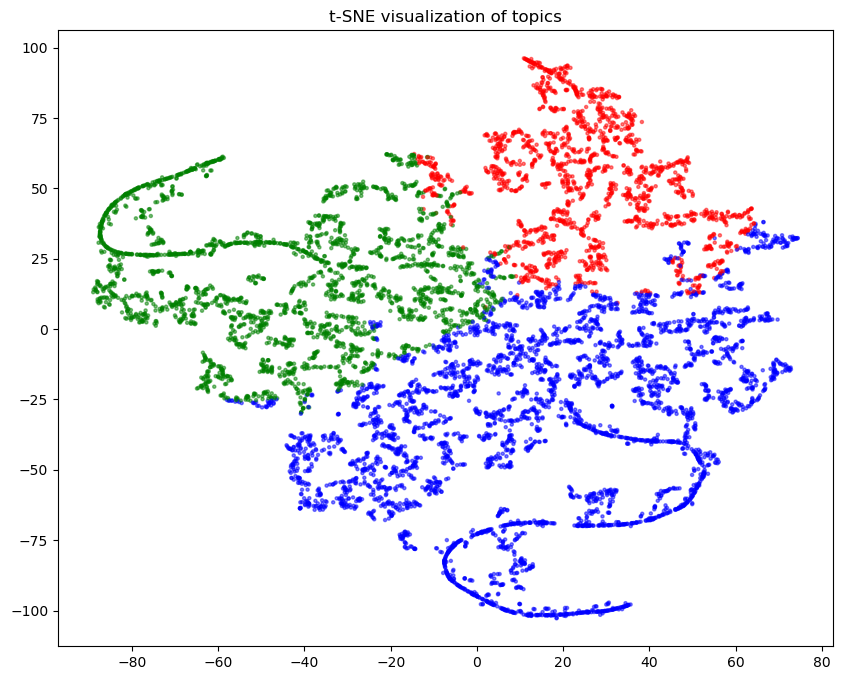

In [229]:
nmf_model_evaluation(nmf_2_model, X_tdif_2, nmf_vectorizer2, feature_names_vec3, data['description_cleaned_merged'], nmf_2_transform)

## Analysis and Experiments

# Experiments on relevance metric with explanation
Here are analysis of the results from several topic modeling experiments using Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF). These methods were applied to textual data to uncover hidden topics based on word co-occurrences. We evaluated multiple configurations of these models, analyzing the resulting perplexity scores and the topics discovered.

#### LDA (Latent Dirichlet Allocation) Results
First LDA Model:

Model Configuration: LatentDirichletAllocation(learning_method='online', random_state=42)
Perplexity: 3495.84

Topic Distribution:

Topic 1: Focuses on themes of crime and mystery (e.g., murder, killer, prison, night).

Topic 2: Revolves around war and conflict (e.g., war, gang, country, crew).

Topic 3: Emphasizes themes of power and politics (e.g., team, brother, drug, force).

Topic 4: Discusses themes of love and relationships (e.g., love, man, woman, fall).

Topic 5: Centers on family, childhood, and adventure (e.g., childhood, family, adventure).

Topic 6: Concerned with investigations and crime (e.g., death, agent, crime, job).

Topic 7: Relates to documentary stories and romance (e.g., documentary, love, woman).

Topic 8: Covers new experiences, change, and family (e.g., new, travel, wife, share).

Topic 9: Discusses school and education (e.g., school, friend, student, time).

Topic 10: Depicts themes of brutality, conflict, and survival (e.g., battle, girl, brutal).
ve, brutal


#### Interpretation:

The LDA model effectively identified distinct themes based on word co-occurrences, with notable focus on themes of crime, love, war, and school. The perplexity score (3495.84) indicates that the model fit the data well but could potentially benefit from further tuning to achieve better topic coherence.

#### NMF (Non-Negative Matrix Factorization) Results
First NMF Model:

Model Configuration: NMF(max_iter=10, n_components=10, random_state=42)
Perplexity: 0.0002
Topic Distribution:

Topic 1: Discusses themes of adventure and world exploration (e.g., adventure, world, dream, time).

Topic 2: Focuses on relationships and family dynamics (e.g., young, man, woman, father).

Topic 3: Highlights documentaries, stories, and exploration (e.g., documentary, series, life, film).

Topic 4: Centers on crime, investigation, and mystery (e.g., murder, investigation, crime, team).

Topic 5: Emphasizes the experiences of students and school life (e.g., school, high, student, teen).

Topic 6: Focuses on starting anew, urban life, and personal growth (e.g., new, life, city, begin).

Topic 7: Discusses family secrets and struggles (e.g., family, father, home, return).

Topic 8: Deals with childhood friendships and adventure (e.g., friend, best, childhood, trip).

Topic 9: Centers on love, relationships, and marriage (e.g., love, fall, way, marriage).

Topic 10: Discusses life changes and relationships (e.g., live, woman, couple, share).


#### Interpretation:

The NMF model produced results with highly relevant topics related to family, crime, relationships, and personal growth. The very low perplexity score (0.0002) indicates that the model fits the data exceedingly well, though the number of iterations and components could be optimized further for better topic richness.

### Count Vectorizer (with More Parameters)
A CountVectorizer was used with various configurations for topic modeling, and the resulting perplexity scores were observed across different numbers of topics.

| Number of Topics | Perplexity Score |
|------------------|------------------|
| 1                | 711.28           |
| 2                | 723.59           |
| 3                | 757.25           |
| 4                | 840.51           |
| 6                | 937.25           |
| 8                | 995.04           |
| 10               | 1057.06          |

From this we tried 3 and 2 topics based on their low perplexity score. however we settled for 3 top (Details in Conclusion)

## Conclusion

###  Conclusion on actual vs expected result
Second LDA Model (with 3 Topics)
LDA Model Configuration:

Model Configuration: LatentDirichletAllocation(learning_method='online', n_components=3, random_state=42)

Perplexity: **770.82**

Topic 1: young, woman, find, love, man, famili, life, get, two, three
Topic 2: new, take, team, power, save, fight, friend, world, citi, special
Topic 3: life, documentari, seri, world, stori, school, mysteri, live, follow, show**

Topic Distributio**n:

Topic 1: Focuses on young love and relationships (e.g., young, woman, love, family).

Topic 2: Emphasizes themes of power, teamwork, and global events (e.g., team, power, save, world).

Topic 3: Covers life stories, documentaries, and school (e.g., life, documentary, school, mystery)

#### Interpretation:

This model identified key themes such as love, teamwork, and personal stories. The 3-topic configuration balances topic interpretability with complexity, and the lower perplexity score (770.82) suggests that this model configuration offers a good fit without being overly complex.


### Recommendations for Future Work
Model Optimization: Experiment with varying the number of components (in both LDA and NMF) and the number of iterations to find the optimal trade-off between perplexity and topic coherence.